<a href="https://colab.research.google.com/github/ownopinion-wq/Economic-Analysis/blob/main/EIRR%E3%80%81B_C%E3%80%81NPV%EF%BC%8B%E3%83%A2%E3%83%B3%E3%83%86%E3%82%AB%E3%83%AB%E3%83%AD%E3%83%BB%E3%82%B7%E3%83%9F%E3%83%A5%E3%83%AC%E3%83%BC%E3%82%B7%E3%83%A7%E3%83%B3_%EF%BC%88%E3%83%86%E3%82%B9%E3%83%88%E6%9C%80%E7%B5%82%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- 基準ケース（ベースケース）の分析結果 ---
NPV (正味現在価値): -15,671 万円
B/C (便益費用比): 0.75
EIRR (経済的内部収益率): 4.69%
----------------------------------------

--- モンテカルロ・シミュレーションの分析結果 ---
シミュレーション回数: 10000回
平均EIRR: 4.92%
EIRRが社会的割引率(6%)を下回る確率: 100.00%
平均B/C: 0.79
B/Cが1を下回る確率: 100.00%


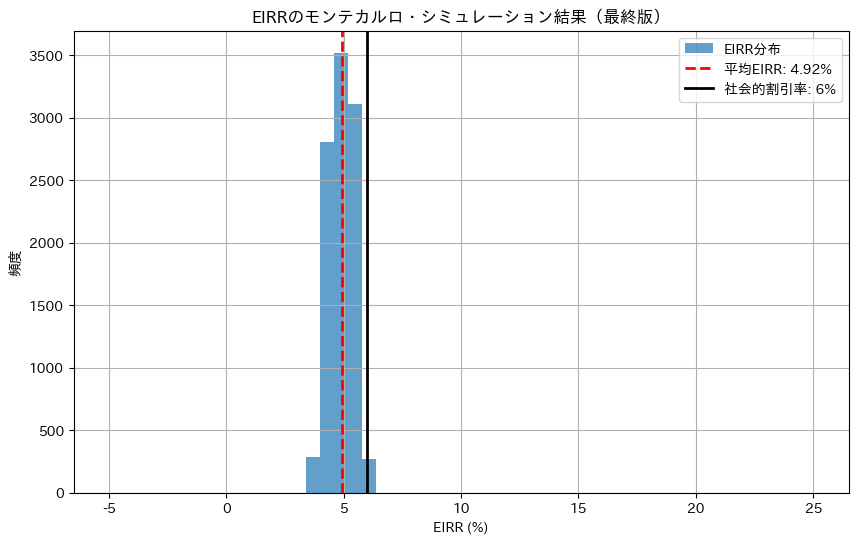

In [ ]:
# STEP 1: 日本語化ライブラリをインストールします
!pip install japanize-matplotlib

# 必要なライブラリをインポートします
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import random
# ★★★ これ1行で、これまでのすべての文字化け対策が不要になります ★★★
import japanize_matplotlib

# --- 1. 基本設定（前提条件） ---
SDR = 0.06
CONSTRUCTION_YEARS = 4
LIFESPAN_YEARS = 50
TOTAL_YEARS = CONSTRUCTION_YEARS + LIFESPAN_YEARS
ECONOMIC_GROWTH_RATE = 0.04
BASE_CONSTRUCTION_COST_TOTAL = 50000
BASE_OM_COST_ANNUAL = 500
BASE_RENEWAL_COST_ANNUAL = 1000
TOTAL_BENEFIT = 100000
NUM_FLOOD_EVENTS = 5
SINGLE_FLOOD_BENEFIT = TOTAL_BENEFIT / NUM_FLOOD_EVENTS

# --- 2. 基準ケース（ベースケース）の分析 ---
print("--- 基準ケース（ベースケース）の分析結果 ---")
construction_cost_annual = BASE_CONSTRUCTION_COST_TOTAL / CONSTRUCTION_YEARS
costs = np.array(
    [construction_cost_annual] * CONSTRUCTION_YEARS +
    [BASE_OM_COST_ANNUAL + BASE_RENEWAL_COST_ANNUAL] * LIFESPAN_YEARS
)
benefits = np.zeros(TOTAL_YEARS)
for i in range(1, NUM_FLOOD_EVENTS + 1):
    year_index = CONSTRUCTION_YEARS + (i * 10) - 1
    years_into_operation = i * 10
    escalated_benefit = SINGLE_FLOOD_BENEFIT * ((1 + ECONOMIC_GROWTH_RATE) ** years_into_operation)
    benefits[year_index] = escalated_benefit
net_cash_flow = np.insert(benefits - costs, 0, 0)
benefits_pv_stream = np.insert(benefits, 0, 0)
costs_pv_stream = np.insert(costs, 0, 0)
npv_base = npf.npv(SDR, net_cash_flow)
bc_base = npf.npv(SDR, benefits_pv_stream) / npf.npv(SDR, costs_pv_stream)
eirr_base = npf.irr(net_cash_flow)
print(f"NPV (正味現在価値): {npv_base:,.0f} 万円")
print(f"B/C (便益費用比): {bc_base:.2f}")
print(f"EIRR (経済的内部収益率): {eirr_base:.2%}")
print("-" * 40)

# --- 3. モンテカルロ・シミュレーション ---
print("\n--- モンテカルロ・シミュレーションの分析結果 ---")
NUM_SIMULATIONS = 10000
construction_cost_multipliers = [1.0, 1.1, 1.2]
renewal_cost_multipliers = [1.0, 1.1, 1.2]
benefit_multipliers = [1.0, 1.1, 1.2, 1.3]
npv_results, bc_results, eirr_results = [], [], []
for _ in range(NUM_SIMULATIONS):
    sim_construction_multiplier = random.choice(construction_cost_multipliers)
    sim_renewal_multiplier = random.choice(renewal_cost_multipliers)
    sim_benefit_multiplier = random.choice(benefit_multipliers)
    sim_construction_cost = (BASE_CONSTRUCTION_COST_TOTAL * sim_construction_multiplier) / CONSTRUCTION_YEARS
    sim_renewal_cost = BASE_RENEWAL_COST_ANNUAL * sim_renewal_multiplier
    sim_base_benefit = SINGLE_FLOOD_BENEFIT * sim_benefit_multiplier
    sim_costs = np.array(
        [sim_construction_cost] * CONSTRUCTION_YEARS +
        [BASE_OM_COST_ANNUAL + sim_renewal_cost] * LIFESPAN_YEARS
    )
    sim_benefits = np.zeros(TOTAL_YEARS)
    for i in range(1, NUM_FLOOD_EVENTS + 1):
        year_index = CONSTRUCTION_YEARS + (i * 10) - 1
        years_into_operation = i * 10
        sim_escalated_benefit = sim_base_benefit * ((1 + ECONOMIC_GROWTH_RATE) ** years_into_operation)
        sim_benefits[year_index] = sim_escalated_benefit
    sim_net_cash_flow = np.insert(sim_benefits - sim_costs, 0, 0)
    sim_benefits_pv = np.insert(sim_benefits, 0, 0)
    sim_costs_pv = np.insert(sim_costs, 0, 0)
    npv_results.append(npf.npv(SDR, sim_net_cash_flow))
    bc_results.append(npf.npv(SDR, sim_benefits_pv) / npf.npv(SDR, sim_costs_pv))
    try:
        eirr_val = npf.irr(sim_net_cash_flow)
        eirr_results.append(eirr_val)
    except:
        eirr_results.append(-1.0)
eirr_results_np = np.array(eirr_results)
bc_results_np = np.array(bc_results)
print(f"シミュレーション回数: {NUM_SIMULATIONS}回")
print(f"平均EIRR: {np.mean(eirr_results_np):.2%}")
print(f"EIRRが社会的割引率({SDR:.0%})を下回る確率: {np.sum(eirr_results_np < SDR) / NUM_SIMULATIONS:.2%}")
print(f"平均B/C: {np.mean(bc_results_np):.2f}")
print(f"B/Cが1を下回る確率: {np.sum(bc_results_np < 1) / NUM_SIMULATIONS:.2%}")

# --- グラフ描画 ---
# ★★★ これまでのfontpropertiesの指定はすべて不要になります ★★★
plt.figure(figsize=(10, 6))
eirr_percent_results = eirr_results_np * 100
plt.hist(eirr_percent_results, bins=50, range=(-5, 25), alpha=0.7, label='EIRR分布')
plt.axvline(np.mean(eirr_percent_results), color='red', linestyle='dashed', linewidth=2, label=f'平均EIRR: {np.mean(eirr_results_np):.2%}')
plt.axvline(SDR * 100, color='black', linestyle='solid', linewidth=2, label=f'社会的割引率: {SDR:.0%}')
plt.title('EIRRのモンテカルロ・シミュレーション結果（最終版）')
plt.xlabel('EIRR (%)')
plt.ylabel('頻度')
plt.legend()
plt.grid(True)
plt.show()